In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
import gc


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [ ]:
# %pip install --user optuna

In [42]:
# import os
# import sys
# os.environ['PATH'] += os.pathsep + '/home/jupyter/.local/bin'
# sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')

In [ ]:
files = ['/home/jupyter/datasphere/project/files/AHS_Woman_08_Rajasthan.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_10_Bihar_Part_1.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_10_Bihar_Part_2.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_18_Assam.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_20_Jharkhand.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_21_Odisha.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_22_Chhattisgarh.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_23_Madhya_Pradesh_Part_1.csv',
         '/home/jupyter/datasphere/project/files/AHS_Woman_23_Madhya_Pradesh_Part_2.csv'
         ]

dfs = [pd.read_csv(file, sep='|') for file in files]
DATA = pd.concat(dfs, ignore_index=True)


del dfs
gc.collect()

In [ ]:
def null_counts(df):
    nulls = pd.DataFrame({
        'columns': df.columns,
        'null_count': [df[col].isnull().sum() for col in df.columns]
    })
    print(nulls.to_string(index=False))
    print(len(df.columns), ' columns; ', len(df), ' columns',)

null_counts(DATA)

In [3]:
def data_preprocessing(df):
    imp_cols = ['state', 'district', 'rural', 'stratum_code', 'age', 'marital_status',
       'born_alive_female', 'born_alive_male', 'born_alive_total',
       'mother_age_when_baby_was_born', 'outcome_pregnancy', 'is_tubectomy',
       'is_vasectomy', 'is_copper_t', 'is_pills_daily', 'is_piils_weekly',
       'is_emergency_contraceptive', 'is_condom', 'is_moder_methods',
       'is_contraceptive', 'is_periodic_abstinence', 'is_withdrawal',
       'is_amenorrahoea', 'is_other_traditional_method',
       'is_currently_pregnant', 'is_currently_menstruating',
       'when_you_bcome_mother_last_time', 'is_any_fp_methos_used',
       'fp_method_used', 'want_more_childern', 'anm_in_last_3_months',
       'during_pregnancy', 'during_lactation', 'aware_abt_rti',
       'aware_abt_hiv', 'aware_of_haf', 'aware_of_the_danger_signs',
       'religion', 'social_group_code', 'year_of_marriage', 'year_of_intr',
       'highest_qualification', 'occupation_status', 'disability_status',
       'injury_treatment_type', 'illness_type', 'treatment_source',
       'symptoms_pertaining_illness', 'diagnosed_for', 'chew', 'smoke',
       'alcohol', 'drinking_water_source', 'is_water_filter', 'toilet_used',
       'household_have_electricity', 'cooking_fuel', 'is_car',
       'ever_conceived', 'age_at_first_conception',
       'is_husband_living_with_you', 'counselled_for_menstrual_hyg',
       'aware_abt_danger_signs_new_born', 'iscoveredbyhealthscheme', 'wt',
       'as_binned', 'surviving_total', 'surviving_female', 'surviving_male', 'delivered_any_baby']

    del_cols = ['surviving_total', 'surviving_female', 'surviving_male',
                'delivered_any_baby', 'born_alive_total',
                'born_alive_male', 'born_alive_female', 'ever_conceived']


    df = df.apply(pd.to_numeric, errors='coerce')

    df = df[df['result_of_interview']==1]
    df = df[df['sex']==2]
    df = df[df['delivered_any_baby']==1]
    df = df[df['born_alive_total'] >= 1]

    df = df[imp_cols]

    df = df.dropna(subset=['surviving_total'])
    
    df['year_of_intr'] = df['year_of_intr'].fillna(2011)
    
    for col in imp_cols:
        null_percent = df[col].isna().mean()
        if null_percent < 0.5:
            if df[col].nunique() < 20:
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna(df[col].median())

        else:
            df[col] = df[col].fillna(-99)
            
    
    # Создание целевой переменной
    df['child_death_risk'] = np.where(df['born_alive_total'] > df['surviving_total'], 1, 0)

    df = df.drop(del_cols, axis=1)
    return df

data_pr = data_preprocessing(DATA)

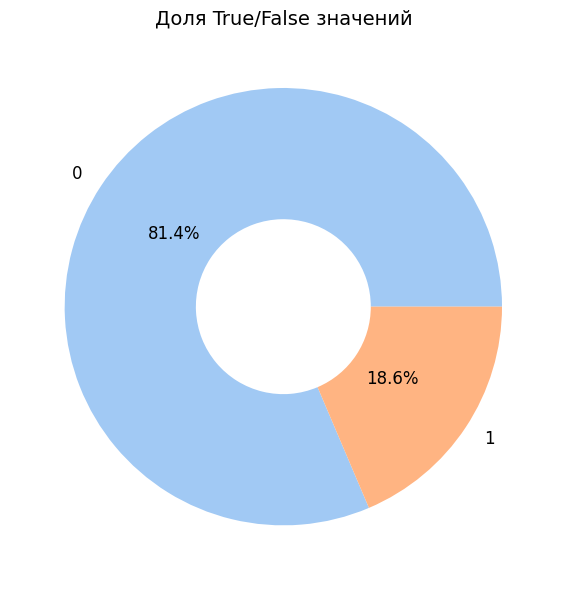

In [55]:
plt.figure(figsize=(6, 6))
data_pr['child_death_risk'].value_counts().plot.pie(
    autopct='%.1f%%',
    colors=sb.color_palette('pastel'),
    wedgeprops={'width': 0.6}, 
    textprops={'fontsize': 12}
)
plt.ylabel('')
plt.title('Доля True/False значений', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
def outliers_1(df):
    df = df[df['aware_of_the_danger_signs'] != 3]
    df = df[df['as_binned'] != 200806003340102.0]
    df = df[(df['want_more_childern'] != 8.0) & (df['want_more_childern'] != 0.0)]
    df = df[(df['stratum_code'] != 3) & (df['stratum_code'] != 5) & (df['stratum_code'] != 6)]
    df = df[(14 < df['age']) & (df['age'] <= 51)]
    df = df[(11 <= df['mother_age_when_baby_was_born']) & (df['mother_age_when_baby_was_born'] <= 49)]
    df = df[(11 <= df['age_at_first_conception']) & (df['age_at_first_conception'] <= 49)]
    df = df[df['is_currently_menstruating'] != 0]
    df = df[df['treatment_source'] != 12]
    df = df[df['smoke'] != 7]
    df = df[df['alcohol'] != 7]

    return df

data_pr = outliers_1(data_pr)

In [ ]:
null_counts(data_pr)

In [5]:
def feature_engineering(df):
    contraception_methods = ['is_tubectomy', 'is_copper_t', 'is_pills_daily', 'is_vasectomy', 'is_piils_weekly', 'is_emergency_contraceptive',
                            'is_condom', 'is_moder_methods']
    trad_methods = ['is_contraceptive', 'is_periodic_abstinence', 'is_withdrawal',
                    'is_amenorrahoea', 'is_other_traditional_method']

    df['modern_contraception_score'] = df[contraception_methods].sum(axis=1)
    df['traditional_contraception_score'] = df[trad_methods].sum(axis=1)
    
    df['age_when_married'] = df['age'] - (df['year_of_intr'] - df['year_of_marriage'])
    

    feature_del_cols = ['is_tubectomy', 'is_copper_t', 'is_pills_daily', 'is_vasectomy', 'is_piils_weekly', 'is_emergency_contraceptive',
                        'is_condom', 'is_moder_methods', 'is_contraceptive', 'is_periodic_abstinence', 'is_withdrawal',
                        'is_amenorrahoea', 'is_other_traditional_method', 'year_of_marriage', 'year_of_intr']
    
    

    for col in df.columns:
        if df[col].nunique() < 20:
            df[col] = df[col].astype('category')
        if df[col].nunique() == 2:
            df[col] = df[col].astype('int32')


    df = df.drop(feature_del_cols, axis=1)
    return df

data_pr = feature_engineering(data_pr)

In [6]:
sort_imp_cols = ['highest_qualification', 'state', 'outcome_pregnancy',
 'year_of_marriage', 'district', 'rural', 'aware_abt_hiv', 'is_currently_menstruating', 'willing_to_get_pregnant',
 'as_binned', 'age_at_first_conception', 'is_husband_living_with_you', 'pregnant_month', 'drinking_water_source',
 'during_lactation', 'wt', 'age', 'modern_contraception_score', 'stratum_code', 'chew', 'injury_treatment_type',
 'mother_age_when_baby_was_born', 'religion', 'iscoveredbyhealthscheme', 'anm_in_last_3_months',
 'want_more_childern', 'aware_of_haf', 'traditional_contraception_score', 'counselled_for_menstrual_hyg',
 'illness_type', 'wealth_index', 'is_any_fp_methos_used', 'fp_method_used', 'during_pregnancy',
 'when_you_bcome_mother_last_time', 'marital_status', 'social_group_code', 'aware_abt_danger_signs_new_born',
 'occupation_status', 'aware_abt_rti', 'aware_of_the_danger_signs', 'disability_status', 'symptoms_pertaining_illness',
 'alcohol', 'smoke', 'diagnosed_for', 'is_anc_registered', 'treatment_source', 'is_currently_pregnant']

num_cols = ['year_of_marriage', 'as_binned', 'age_at_first_conception', 'wt', 'age', 'modern_contraception_score', 
 'mother_age_when_baby_was_born', 'traditional_contraception_score', 'when_you_bcome_mother_last_time', 'occupation_status']


cat_cols = data_pr.select_dtypes(include=['category']).columns

In [7]:
def outliers_2(df):
    df = df[df['modern_contraception_score'] != 6.0]
    df = df[df['traditional_contraception_score'] != 2.0]
    df = df[(4 <= df['age_when_married']) & (df['age_when_married'] <= 50)]
    
    encoder = OneHotEncoder(sparse=True)
    encoded_data = encoder.fit_transform(df[cat_cols])
    print('encoded')
    
    model = IsolationForest(
        n_estimators=80,
        max_samples=100_000,
        n_jobs=32,
        contamination=0.02
    )
    model.fit(encoded_data.toarray())
    print('fited')
    
    df = df[model.predict(encoded_data) == 1]
    return df

data_pr = outliers_2(data_pr)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


encoded
fited
6774085


In [ ]:
def data_analise(df):
    for col in df.columns:
        print(col)
        print(df[col].value_counts(), '\n')

data_analise(data_pr)

In [8]:
y = data_pr['child_death_risk']
X = data_pr.drop('child_death_risk', axis=1)

In [9]:
# Разделение выборки на тренировочную, валидационную и тестовую
X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.2, stratify=y)
X_t, X_val, y_t, y_val = train_test_split(X_t, y_t, test_size=0.2, stratify=y_t)

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier

scale_pos_weight = (len(y_tr) - y_tr.sum()) / y_tr.sum()
#scale_pos_weight = 8
def objective(trial):
    params = {
        'learning_rate': 0.05,
        'max_depth': trial.suggest_int('max_depth', 20, 27),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'n_estimators': 1500,
        'n_jobs': 8  # 32 ядра / 4 параллельных trial → 8 на процесс
    }

    # Стратегия для быстрого поиска
    sample_fraction = min(0.1 + trial.number*0.015, 0.4)  # Прогрессивный семплинг
    X_sample, _, y_sample, _ = train_test_split(
        X_tr, y_tr, 
        train_size=sample_fraction,
        stratify=y_tr,
        random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_sample, y_sample,
        test_size=0.2,  # 20% данных из sample_fraction идут в валидацию
        stratify=y_sample,
        random_state=42
    )

    model = XGBClassifier(
        **params,
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        objective="binary:logistic",
        tree_method="hist",
        early_stopping_rounds=20,
        enable_categorical=True
    )

    # Ускоренное обучение с кэшированием
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Быстрая оценка
    preds = model.predict_proba(X_val)[:, 1][::10]  # Подвыборка для предсказаний
    return average_precision_score(y_val[::10], preds)

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(
        n_startup_trials=10,
        multivariate=True,
        group=True
    )
)

study.optimize(
    objective, 
    n_trials=100,
    n_jobs=32,
    show_progress_bar=True,
    gc_after_trial=True
)

In [ ]:
from xgboost import XGBClassifier

scale_pos_weight = (len(y_tr) - y_tr.sum()) / y_tr.sum()
#scale_pos_weight = 8
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth = 27,
    learning_rate = 0.05,
    subsample = 0.95,
    colsample_bytree =0.61,
    gamma = 2.6,
    reg_alpha = 0.52,
    reg_lambda = 2.3,
    early_stopping_rounds=20,
    random_state=42,
    eval_metric='aucpr', #eval_metric='logloss',
    objective="binary:logistic",
    enable_categorical=True,
    tree_method = "hist",
    n_jobs = 32,
    scale_pos_weight=scale_pos_weight,
    importance_type='gain'
)
xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

In [12]:
from sklearn.metrics import roc_auc_score, classification_report

def analise(model):
    preds = model.predict(X_t)
    acc = accuracy_score(y_t, preds)
    print(f"Accuracy: {acc:.4f}")
    
    percent = preds.sum() / len(preds) * 100
    print(f"Death predicted percent: {percent:.4f}")
    
    deathIsTruePerc = ((preds == 1) & (preds == y_t)).sum()/preds.sum()
    print(f"Правильность предсказания смертности: {deathIsTruePerc:.4f}")
    
    deathFoundPerc = ((preds == 1) & (preds == y_t)).sum()/y_t.sum()
    print(f"Процент найденных случаев смертности: {deathFoundPerc:.4f}")
    
    print(f"Final ROC-AUC: {roc_auc_score(y_t, preds):.4f}")
    print(classification_report(y_t, preds))
    
analise(xgb)

Accuracy: 0.8073
Death predicted percent: 20.7703
Правильность предсказания смертности: 0.4823
Процент найденных случаев смертности: 0.5406
Final ROC-AUC: 0.7043
              precision    recall  f1-score   support

           0       0.89      0.87      0.88    883026
           1       0.48      0.54      0.51    200827

    accuracy                           0.81   1083853
   macro avg       0.69      0.70      0.69   1083853
weighted avg       0.82      0.81      0.81   1083853



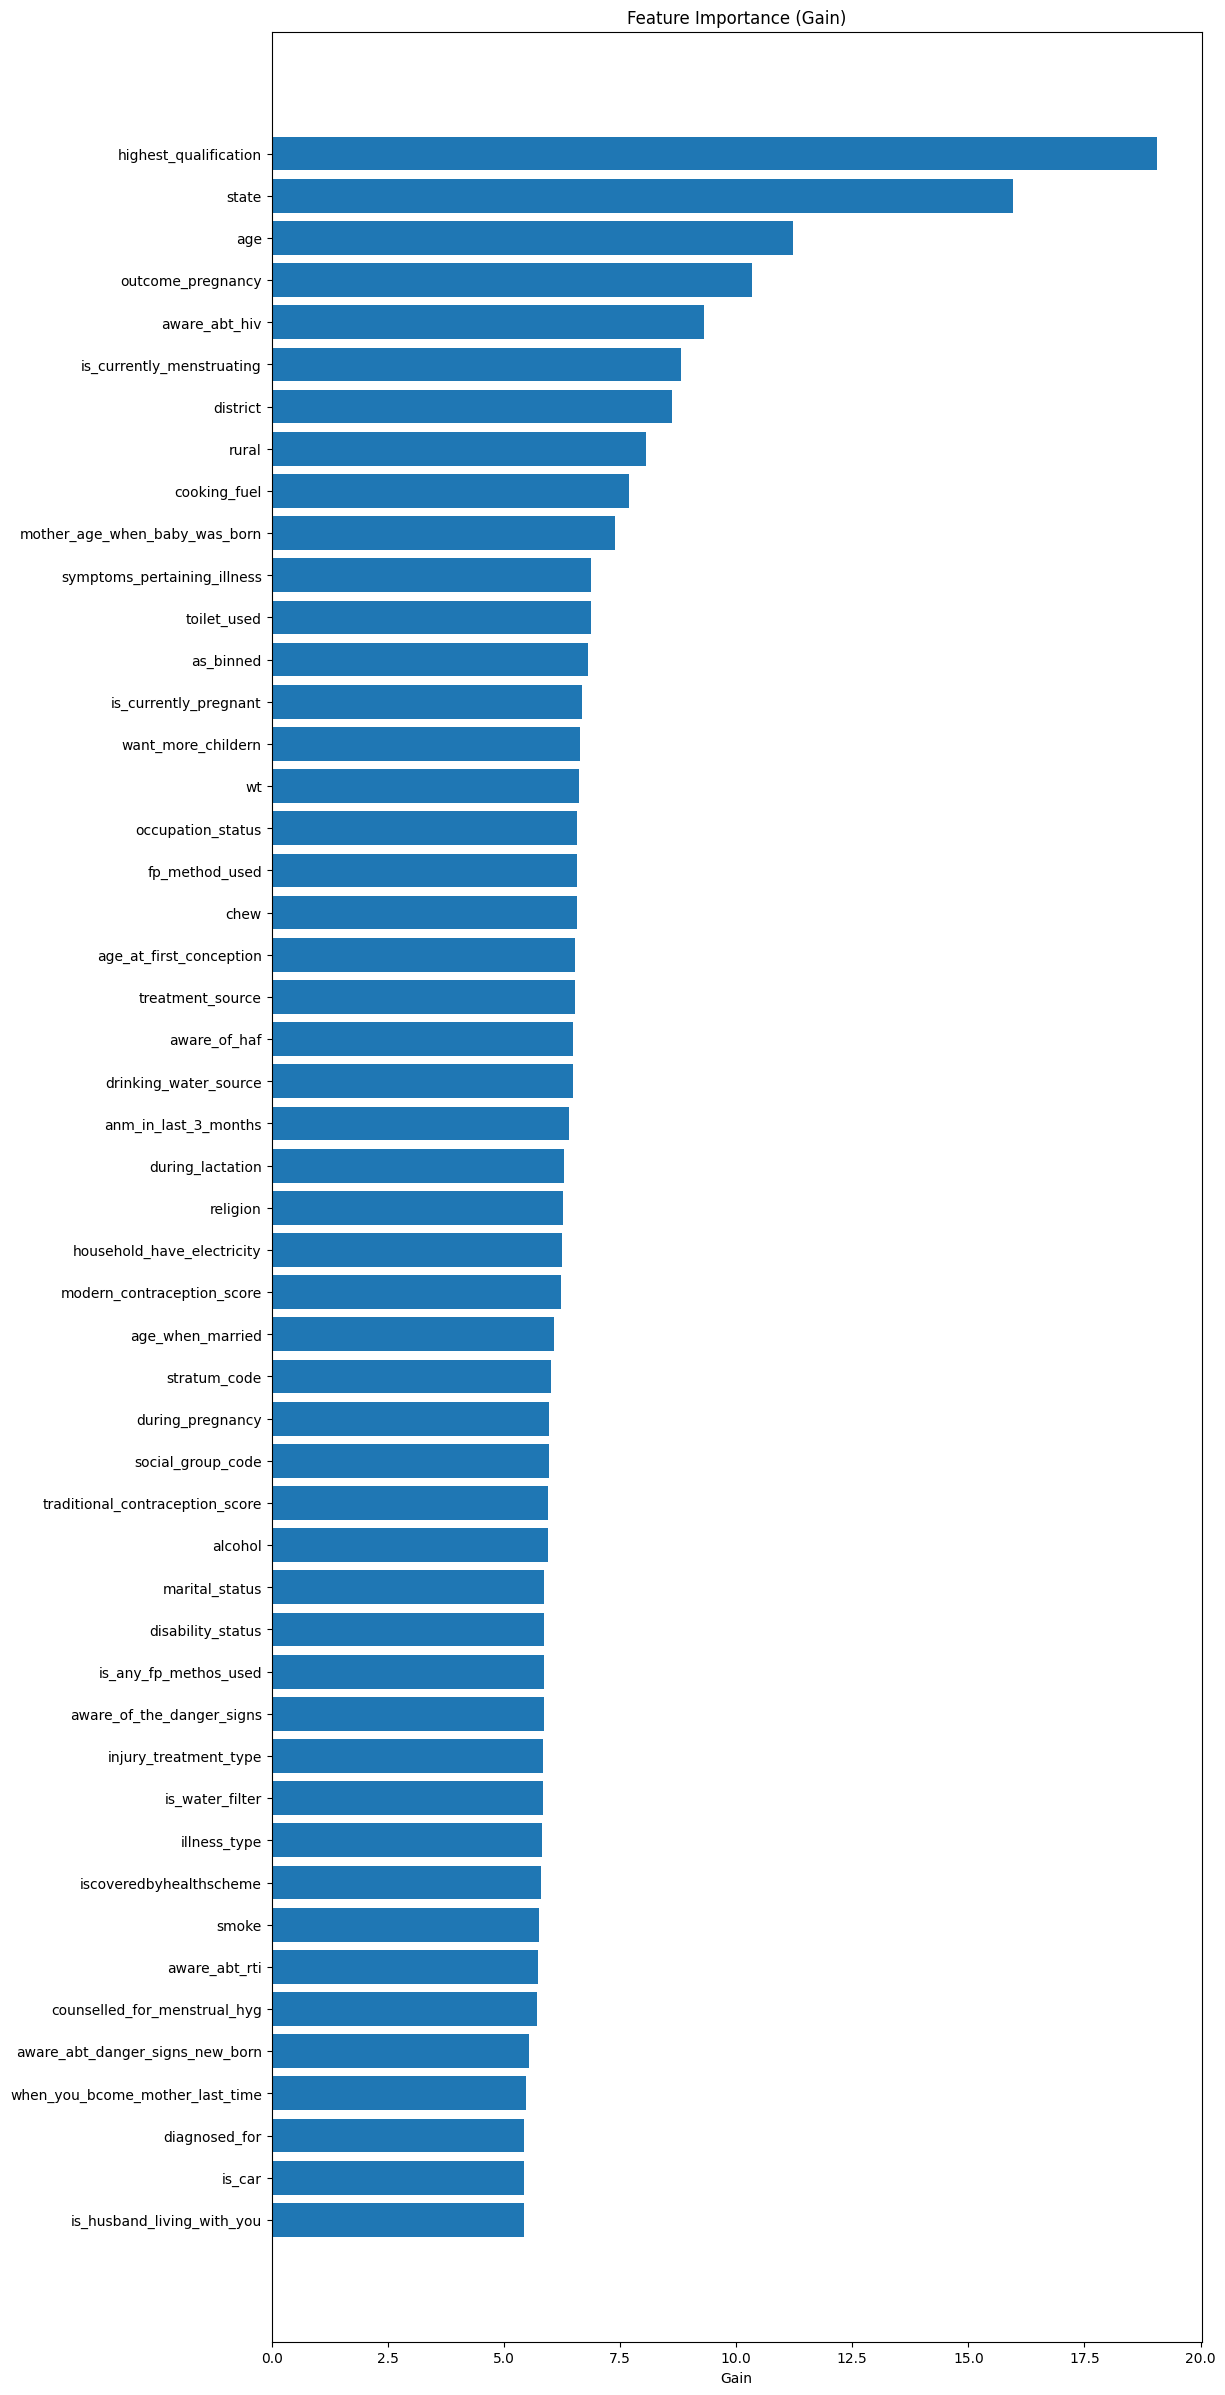

['highest_qualification',
 'state',
 'age',
 'outcome_pregnancy',
 'aware_abt_hiv',
 'is_currently_menstruating',
 'district',
 'rural',
 'cooking_fuel',
 'mother_age_when_baby_was_born',
 'symptoms_pertaining_illness',
 'toilet_used',
 'as_binned',
 'is_currently_pregnant',
 'want_more_childern',
 'wt',
 'occupation_status',
 'fp_method_used',
 'chew',
 'age_at_first_conception',
 'treatment_source',
 'aware_of_haf',
 'drinking_water_source',
 'anm_in_last_3_months',
 'during_lactation',
 'religion',
 'household_have_electricity',
 'modern_contraception_score',
 'age_when_married',
 'stratum_code',
 'during_pregnancy',
 'social_group_code',
 'traditional_contraception_score',
 'alcohol',
 'marital_status',
 'disability_status',
 'is_any_fp_methos_used',
 'aware_of_the_danger_signs',
 'injury_treatment_type',
 'is_water_filter',
 'illness_type',
 'iscoveredbyhealthscheme',
 'smoke',
 'aware_abt_rti',
 'counselled_for_menstrual_hyg',
 'aware_abt_danger_signs_new_born',
 'when_you_bcome_

In [13]:
importance = xgb.get_booster().get_score(importance_type='gain')

# Создание DataFrame для визуализации
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'gain': list(importance.values())
}).sort_values('gain', ascending=False)

plt.figure(figsize=(12, 30))
plt.barh(importance_df['feature'], importance_df['gain'])
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()
plt.show()

list(importance_df['feature'])